In [31]:
# 표준 라이브러리
from typing import Literal
from typing_extensions import TypedDict, List
import os 

# 서드파티 라이브러리
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, START, END
from pyzerox import zerox

# LangChain 관련 라이브러리
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import (
    PyPDFLoader,
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
import markdown
from bs4 import BeautifulSoup
from datetime import date

load_dotenv()


True

In [11]:
MODEL_NAME = "gemma2-9b-it"

llm = ChatGroq(model_name=MODEL_NAME)
small_llm = ChatGroq(model_name=MODEL_NAME)

In [13]:
# 프롬프트
rag_prompt = hub.pull("rlm/rag-prompt")



In [46]:
class AgentState(TypedDict):
    query: str
    answer: str

    tax_base_equation: str # 과세표준 계산 수식
    tax_deduction: str # 공제액
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산
    

In [5]:
text_path = './documents/real_estate_tax.txt'

markdown_path ="./documents/real_estate_tax.md"

# 마크다운 파일
with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()

# 마크다운 콘텐츠를 HTML로 변환
html_content = markdown.markdown(md_content)

# HTML 콘텐츠를 파싱하여 텍스트만 추출합니다
soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

# 추출한 텍스트를 텍스트 파일로 저장
with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)

print("Markdown converted to plain text successfully!")

Markdown converted to plain text successfully!


In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500, 
    chunk_overlap = 100,
    separators=['\n\n','\n']
)

In [7]:

loader = TextLoader(text_path, encoding='utf-8')
document_list = loader.load_and_split(text_splitter)

In [8]:
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sroberta-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)


C:\Users\user\AppData\Local\Temp\ipykernel_2340\2544830205.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(
c:\USERS\USER\DESKTOP\FINBRAINAGENT\VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:


vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings_model,
    collection_name = "real_estate_tax",
    persist_directory = "./real_estate_tax_collection"
)


# 이미 생성된 크로마 db 가져오기
# vector_store = Chroma(
#     embedding_function=embeddings_model,
#     collection_name = "income_tax_collection",
#     persist_directory = "./income_tax_collection"
# )

retriever = vector_store.as_retriever(search_kwargs = {"k":3})

In [47]:
tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자 질문에서 과세표준을 계산하는 방법을 수식으로 나타내라. 부연 설명없이 수식만 나타내라.'),
    ('human', "{tax_base_equation_information}")
])


In [48]:
tax_base_retrieval_chain = (
    {"context":retriever, "question": RunnablePassthrough()}
    | rag_prompt 
    | llm 
    | StrOutputParser()
    )

tax_base_equation_chain = (
    {'tax_base_equation_information':RunnablePassthrough()} 
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()
    )

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

In [49]:
def get_tax_base_equation(state: AgentState) -> str:
    tax_base_equation_question = "주택에 대한 종합부동산세 계산 시 과세표준 계산 방법을 수식으로 표현해서 알려줘라"
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {'tax_base_equation':tax_base_equation}


In [50]:
get_tax_base_equation({})

{'tax_base_equation': 'Tax Base = Σ(House Price) * Fair Market Value Ratio \n'}

In [51]:
tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState) -> AgentState:
    # 공제금액을 묻는 질문
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction': tax_deduction}

In [52]:
tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

tax_market_ratio_chain = (
    tax_market_ratio_prompt
    | llm
    | StrOutputParser()
)

def get_market_ratio(state: AgentState):
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇%인가요?'
    context = tavily_search_tool.invoke(query)
    market_ratio= tax_market_ratio_chain.invoke({'context' :context, 'query':query})
    return {'market_ratio':market_ratio}




In [53]:
get_market_ratio({})

{'market_ratio': '제공된 정보를 바탕으로 2025년 3월 11일 공시가격에 적용되는 공정시장가액비율을 정확하게 계산할 수는 없습니다. \n\n다음과 같은 이유 때문입니다.\n\n* **2025년 공시가격은 2020년 시세반영률로 동결:**  2020년의 시세반영률은 공정시장가액비율과 뚜렷하게 연관되어 있지 않아 직접적으로 계산할 수 없습니다.\n* **공정시장가액비율의 변동:** 과거 80%로 유지되었던 공정시장가액비율이 현재 60%로 변경되었고, 2024년에는 43~45%로 변경되었습니다.  이러한 변동성은 앞으로도 지속될 수 있으며 2025년 3월 11일의 정확한 비율을 예측하기 어렵습니다.\n\n**결론적으로, 제공된 정보만으로는 2025년 3월 11일 공시가격에 적용되는 공정시장가액비율을 정확하게 계산할 수 없습니다.** \n\n\n자세한 정보는 국토교통부 또는 관련 부처의 공식 발표를 참조하시기 바랍니다. \n'}

In [54]:
# 과세표준 계산

tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',"""
주어진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 공식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}"""),
        ('human', '사용자 주택 공시가격 정보: {query}')
    ]
)

def calculate_tax_base(state: AgentState) -> AgentState:
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    
    # tax_base_calculation_chain을 구성하여 과세표준을 계산
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )

    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })


    return {'tax_base': tax_base}

In [55]:
# 세율 , 세액 계산

tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

과세표준: {tax_base}
주택 수:{query}''')
])

def calculate_tax_rate(state: AgentState):

    query = state['query']
    tax_base = state['tax_base']
    

    context = retriever.invoke(query)
    
    # tax_rate_chain을 구성하여 세율을 계산
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_rate_chain을 사용하여 세율을 계산
    tax_rate = tax_rate_chain.invoke({
        'context': context, 
        'tax_base': tax_base, 
        'query': query
    })

    # state에서 'answer' 키에 대한 값을 반환
    return {'answer': tax_rate}


In [56]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

graph = graph_builder.compile()

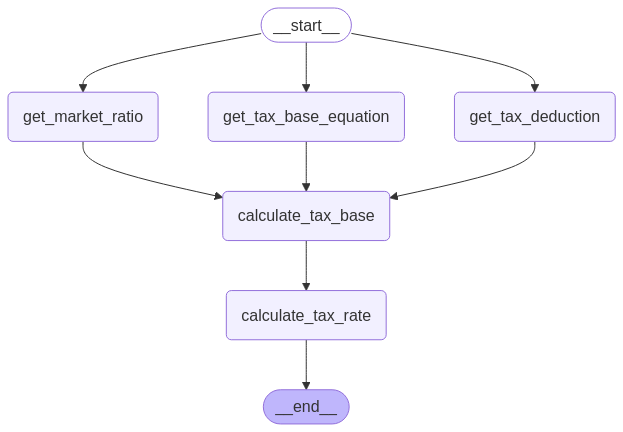

In [57]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'
initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '제공해 주신 정보를 바탕으로 종합부동산세를 계산해 보겠습니다. \n\n**1. 공시가격 합계**\n\n* 5억짜리 집 1채 + 10억짜리 집 1채 + 20억짜리 집 1채 = 35억원\n\n**2. 공제금액 산출**\n\n* 사용자는 3주택 이상을 소유하고 있으므로 공제금액은 12억원이 아닌, 25억원입니다.\n\n**3. 과세표준 계산**\n\n* 과세표준 = (공시가격 합계 - 공제금액) * 공정시장가액비율\n* 과세표준 = (35억 - 25억) * 0.43 (공정시장가액비율의 낮은 측면을 적용)\n* 과세표준 = 10억 * 0.43 = 4300만원\n\n**4. 세율 계산 및 세액 산출**\n\n* 4300만원의 과세표준은 25억원 초과 50억원 이하에 해당합니다. 따라서 세율은 2천650만원 + (25억원 초과하는 금액의 1천분의 15) 입니다.\n* 세액 = 2650만원 + (4300만원 - 25억원) * 0.015\n* 세액 = 2650만원 + 100만원\n* 세액 = 2750만원\n\n**따라서 사용자는 2750만원의 종합부동산세를 내야 합니다.**\n\n\n\n**참고:** \n\n* 위 계산은 공정시장가액비율의 낮은 측면 (43%)을 적용하여 산출되었습니다. \n* 공정시장가액비율이 45%로 높아지면 세금액은 더 높아집니다.\n\n\n\n',
 'tax_base_equation': '```\nTax Base = (Sum of Declared Prices of Housing) - (Deduction Amount) * (Fair Market Value Ratio) \n```',
 'tax_deduction': '주택에 대한 종합부동산세 과세표준은 납세의무자별로 주택의 공시가격을 합산한 금액에서 공제금액을 공제한 금액에 대통령령으로 정하는 공정시장가액비율을 곱한 금액으로 한다. 공제금액은 1세대 1주택자는 